In [38]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yasserh/titanic-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\gabriel.aguirre\.cache\kagglehub\datasets\yasserh\titanic-dataset\versions\1


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [66]:
import glob 
import os
import pandas as pd
import numpy as np
# -------------------------------------------------
# Configurações do pandas
# -------------------------------------------------
pd.set_option('display.max_columns', None)          # Show all columns
pd.set_option('display.width', None)                # Adjust width dynamically
pd.set_option('display.expand_frame_repr', False)   # Prevent column wrapping


df_csv = glob.glob(os.path.join(path, '**.csv'))

df = pd.read_csv(df_csv[0])

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    str    
 4   Sex          891 non-null    str    
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    str    
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    str    
 11  Embarked     889 non-null    str    
dtypes: float64(2), int64(5), str(5)
memory usage: 83.7 KB


In [41]:
df.drop('PassengerId', axis=1, inplace=True)
df.drop('Cabin', axis=1, inplace=True)

In [42]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [43]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Embarked'],
      dtype='str')

In [44]:
df.isna().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
dtype: int64

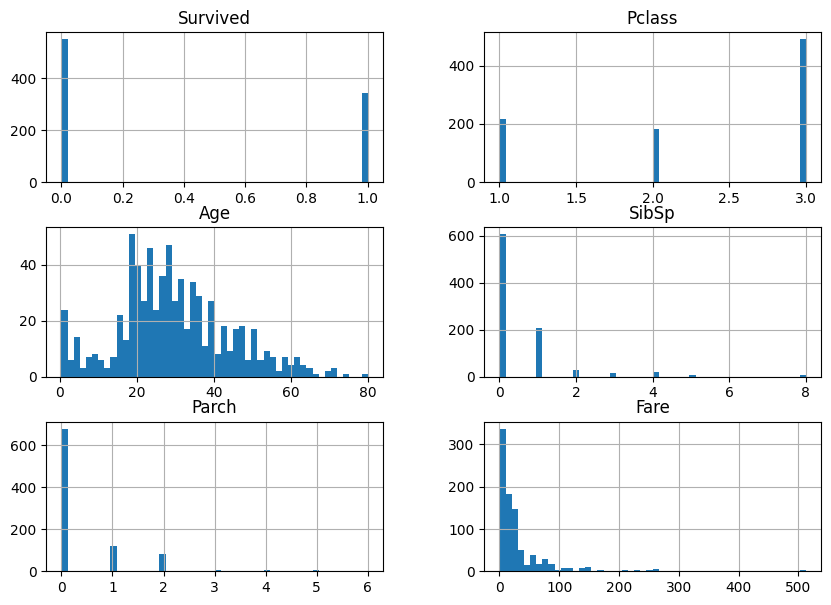

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

df.hist(bins=50, figsize=(10,7))
plt.show()

<Axes: xlabel='Pclass', ylabel='Survived'>

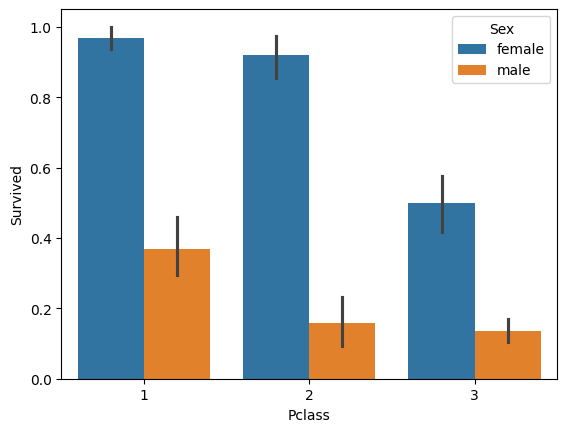

In [46]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df)

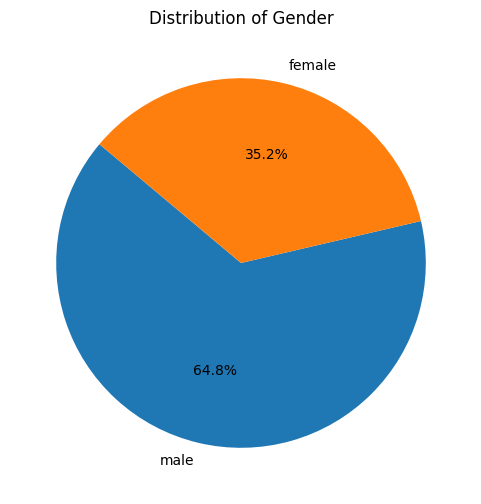

In [47]:
gender_counts = df['Sex'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Gender')
plt.show()


In [48]:
#Realizando correlação
corr_matrix = df.corr(numeric_only=True)

# Correlação em relação ao preço médio da casa
corr_matrix['Survived'].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

In [ ]:
train_set, test_set = train_test_split(df,
                                       test_size=0.2,
                                       random_state=42,
                                       stratify=df['Survived'])

In [ ]:
# Salvando apenas o que sobreviveram
train_labels = train_set['Survived'].copy()

# Removendo passageiros que sobreviveram
train_set = train_set.drop('Survived', axis=1)

In [51]:
# Definindo colunas para cada tipo de tratamento
num_features = ['Age', 'Fare', 'SibSp', 'Parch', 'Pclass']

cat_features = ["Sex", "Embarked"]

# Criando pipelines específicos para cada tipo de coluna
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scale', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

# Unindo tudo
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
], remainder='drop') # 'drop' descarta colunas não listadas 

In [52]:
train_prepared = full_pipeline.fit_transform(train_set)

In [53]:
train_prepared

array([[-0.08113533,  0.5138115 , -0.46508428, ...,  0.        ,
         0.        ,  1.        ],
       [-0.08113533, -0.66256323, -0.46508428, ...,  0.        ,
         0.        ,  1.        ],
       [-0.08113533,  3.95539858, -0.46508428, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.41700669,  0.0532047 ,  0.47833454, ...,  0.        ,
         0.        ,  1.        ],
       [ 1.34017889,  0.13909685, -0.46508428, ...,  0.        ,
         0.        ,  1.        ],
       [-0.08113533, -0.10973011, -0.46508428, ...,  0.        ,
         0.        ,  1.        ]], shape=(712, 10))

In [54]:
# Salvando apenas o que sobreviveram
test_labels = test_set['Survived'].copy()


In [55]:
test_prepared = full_pipeline.transform(test_set)

# **ML MODELS**

In [56]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier

In [57]:
# -------------------------------------------------
# Modelos utilizados
# -------------------------------------------------
model_accuracies = {}
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision tree': DecisionTreeClassifier(max_depth=5),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=1000, 
                                                             random_state=42,
                                                             n_iter_no_change=10),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=300,
                                                     max_depth=6,
                                                     random_state=42)
}

for name, model in models.items():
    
    # Ensinando modelos
    model.fit(train_prepared, train_labels)

    # Score de precisão no treino e teste
    score_in_train = model.score(train_prepared, train_labels)
    score_in_test = model.score(test_prepared, test_labels)

    # Salvando precisões 
    model_accuracies[name] = [score_in_train, score_in_test]

    # Printando saidas
    print(f'------------------------------------------')
    print(f'{name}')
    print(f'score do modelo no treino', round(score_in_train, 3))
    print(f'score do modelo no teste', round(score_in_test,3))
    print(f'cross_val_score do modelo no teste', cross_val_score(model, train_prepared, train_labels, cv=3))

# -------------------------------------------------
# Utilizando voting classifier
# -------------------------------------------------

voting_clf = VotingClassifier(
    estimators=list(models.items()),
    voting='soft'  # 'soft' geralmente é melhor pois usa as probabilidades das previsões
)
print('------------------------------------------')
voting_clf.fit(train_prepared, train_labels)
score_in_test = voting_clf.score(test_prepared, test_labels)
score_in_train = voting_clf.score(train_prepared, train_labels)
print('Score do modelo voting classifier', round(score_in_test,3))
print(f'cross_val_score do modelo voting classifier no teste \n', cross_val_score(voting_clf, train_prepared, train_labels, cv=3))


------------------------------------------
Logistic Regression
score do modelo no treino 0.808
score do modelo no teste 0.804
cross_val_score do modelo no teste [0.78151261 0.78481013 0.81012658]
------------------------------------------
KNN
score do modelo no treino 0.85
score do modelo no teste 0.816
cross_val_score do modelo no teste [0.78151261 0.83544304 0.80168776]
------------------------------------------
Decision tree
score do modelo no treino 0.865
score do modelo no teste 0.76
cross_val_score do modelo no teste [0.80252101 0.8185654  0.81434599]
------------------------------------------
GradientBoostingClassifier
score do modelo no treino 0.893
score do modelo no teste 0.804
cross_val_score do modelo no teste [0.80672269 0.83966245 0.82278481]
------------------------------------------
RandomForestClassifier
score do modelo no treino 0.871
score do modelo no teste 0.81
cross_val_score do modelo no teste [0.81932773 0.83122363 0.82278481]
-----------------------------------

In [58]:
model_accuracies['Voting Classifier'] = [score_in_test, score_in_train]

In [59]:
model_accuracies = pd.DataFrame(model_accuracies, index=['Train accuracy', 'Test accuracy']).T

model_accuracies.sort_values(by='Test accuracy', ascending=False, inplace=True)

In [60]:
model_accuracies

,Train accuracy,Test accuracy
Voting Classifier,0.826816,0.869382
KNN,0.849719,0.815642
RandomForestClassifier,0.870787,0.810056
Logistic Regression,0.807584,0.804469
GradientBoostingClassifier,0.893258,0.804469
Decision tree,0.865169,0.759777


In [61]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(test_prepared, test_labels))

Logistic Regression = 0.8044692737430168
KNN = 0.8156424581005587
Decision tree = 0.776536312849162
GradientBoostingClassifier = 0.8044692737430168
RandomForestClassifier = 0.8100558659217877


In [ ]:
# Melhorando hiperparâmetros de Logistic Regression
lr_param = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=1000), 
    lr_param, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

lr_grid.fit(train_prepared, train_labels)

print("Best LR params:", lr_grid.best_params_)
print("Best LR score:", lr_grid.best_score_)

Best LR params: {'C': 0.1, 'solver': 'lbfgs'}
Best LR score: 0.8020388062641584


In [ ]:
# Melhorando hiperparâmetros de Decision tree

dc_param = {
    'max_depth': [4, 6, 10, 15],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_depth': np.arange(1, 15, 1)
}

dc_grid = GridSearchCV(
    DecisionTreeClassifier(), 
    dc_param, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

dc_grid.fit(train_prepared, train_labels)

print("Best DTC params:", dc_grid.best_params_)
print("Best DTC score:", dc_grid.best_score_)

Best LR params: {'max_depth': np.int64(8), 'min_samples_leaf': 1, 'min_samples_split': 5}
Best LR score: 0.8245543189205161


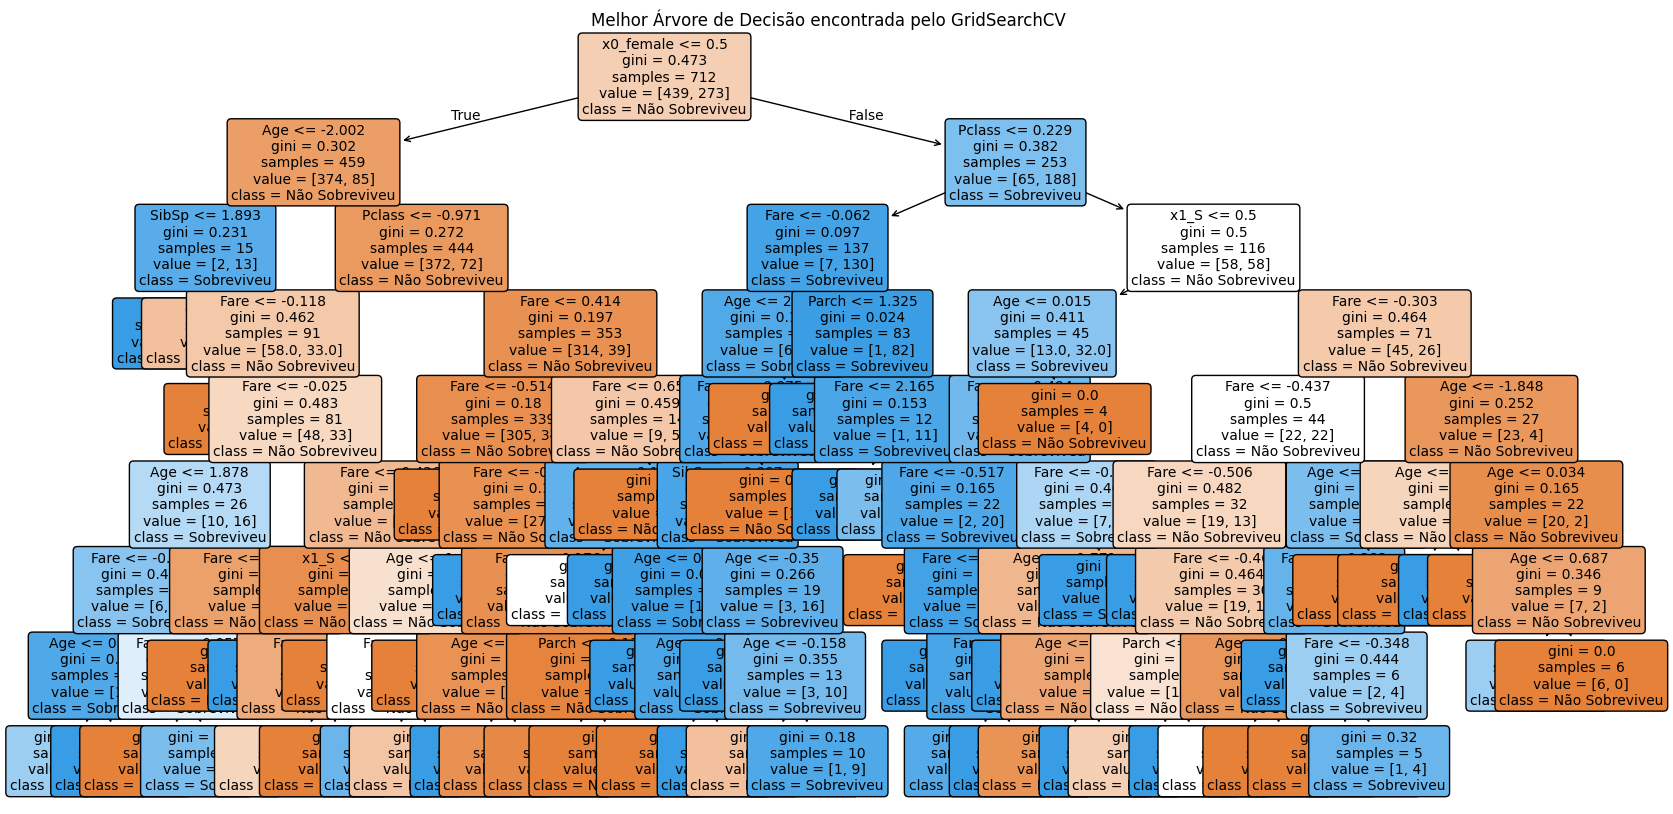

In [73]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Ajuste o tamanho da figura para melhor visualização
plt.figure(figsize=(20, 10))

# O truque é usar o .best_estimator_
plot_tree(
    dc_grid.best_estimator_, 
    feature_names=num_features + list(full_pipeline.named_transformers_['cat']['one_hot'].get_feature_names_out()), # Nomes das colunas processadas
    class_names=["Não Sobreviveu", "Sobreviveu"], # Classes do Titanic
    filled=True,      
    rounded=True,     
    fontsize=10       
)

plt.title("Melhor Árvore de Decisão encontrada pelo GridSearchCV")
plt.show()

In [ ]:
# Melhorando hiperparâmetros de RandomForestClassifier

rfc_param = {
    'n_estimators':np.arange(100,1000,100),
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_depth': [3,5,8]
}

rfc_grid = GridSearchCV(
    RandomForestClassifier(), 
    rfc_param, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1
)

rfc_grid.fit(train_prepared, train_labels)

print("Best RFC params:", rfc_grid.best_params_)
print("Best RFC score:", rfc_grid.best_score_)

c:\Users\gabriel.aguirre\Documents\ML_aguirre\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best RFC params: {'max_depth': np.int64(12), 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': np.int64(300)}
Best RFC score: 0.8301684231261696


In [89]:
# Melhorando hiperparâmetros de Boosting

gbc_param = {
    'loss':['log_loss', 'exponential'],
    'learning_rate':[0.1,0.001],
    'n_estimators':[100,500],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_depth': [3,5,8]
}

gbc_grid = GridSearchCV(
    GradientBoostingClassifier(), 
    gbc_param, 
    cv=5, 
    scoring='accuracy',
    n_jobs=4, verbose=2
)

gbc_grid.fit(train_prepared, train_labels)

print("Best GBC params:", gbc_grid.best_params_)
print("Best GBC score:", gbc_grid.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best GBC params: {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 100}
Best GBC score: 0.8245937161430119


In [ ]:
gbc_random = RandomizedSearchCV(
    GradientBoostingClassifier(), 
    gbc_param, 
    n_iter=50, # Testa apenas 50 combinações aleatórias
    cv=5, 
    scoring='accuracy',
    n_jobs=4, 
    verbose=2,
    random_state=42
)
gbc_random.fit(train_prepared, train_labels)
print("Best GBC params:", gbc_random.best_params_)
print("Best GBC score:", gbc_random.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best GBC params: {'n_estimators': np.int64(700), 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_depth': np.int64(4), 'loss': 'log_loss', 'learning_rate': 0.001}
Best GBC score: 0.8245050723923963
